1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Text(0, 0.5, '$Nor(x)$')

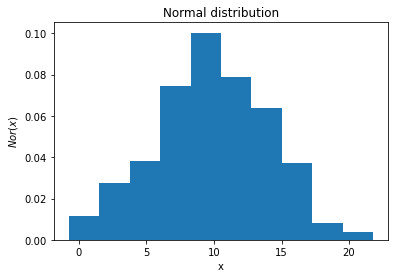

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# always useful
import numpy as np
import math
import random

# There are various methods of generating a int normally distributed from a uniform distribution.
# One of them consist of generating a uniform variable, and using the normal distribution in order to
# evaluate the probability of accepting that uniformly generated data

# Let's define a function that gives back that value:
def normalfunction(mean, stdev, x):
    esponente = -( (( x - mean ) / stdev )**2 / 2 )
    denominator = stdev * math.sqrt( 2*math.pi )
    
    return math.exp(esponente) / denominator

def arraynormallydistributed(mean, stdev, N):
    l = []
    
    i = 0
    while i < N:
        # since the number of data to generate is O(100) we can generate them in an interval of 4 sigma, there's
        # only a small probability (1 - 0.999936) to get a value further that 4 sigma.
        # NB if N had been bigger, one should be consider a bigger sigma
        randvalue = ( random.random() - 0.5 ) * 6 * stdev + mean
        probrandvalue = random.random()
        
        #print(probrandvalue, normalfunction(mean, stdev, randvalue))
        if probrandvalue < normalfunction(mean, stdev, randvalue):
            l.append(randvalue)
            #np.append(l, randvalue, axis=None)
            i += 1
            
    x = np.array(l)
    return x

N = 500
mean = 10
stdev = 4
x = arraynormallydistributed(mean,stdev,N)
#print(x)
ax = plt.hist(x, density=True)
plt.title('Normal distribution')
plt.xlabel('x')
plt.ylabel('$Nor(x)$')

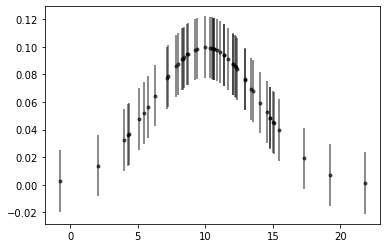

In [21]:
y = []
for i in range(x.size):
    y.append(normalfunction(mean, stdev, x[i]))

# There are two many data samples! Let us visualize only 1/10th of them
nx = []
ny = []
nyerr = []
for i in range(x.size):
    if i%10 == 0:
        nx.append(x[i])
        ny.append(y[i])
        nyerr.append(math.sqrt(N))

plt.errorbar(nx, ny, yerr=math.sqrt(N)/1000, fmt='.k',alpha=.6);

# yerr=math.sqrt(N)/1000 If i didn't divide by 1000, the graph could not not be representable

<ipython-input-27-2b1ce7cb5c27>:27: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(X, Y/10, c=(0.25, 0.25, 1.00), lw=2, label="Blue signal", color='y', zorder=10,alpha=0.1)


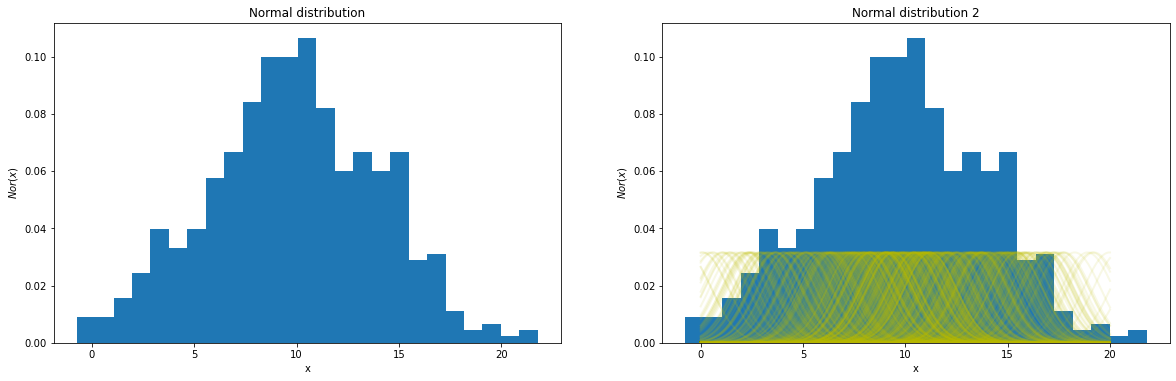

In [27]:
import scipy

singlestdev = 1.06*x.std()*(x.size**(-1/5))

gridsize = (3, 2)
fig = plt.figure(figsize=(20, 20))

ax = plt.subplot2grid(gridsize, (1, 0))
ax = plt.hist(x, bins=N//20, density=True)
plt.title('Normal distribution')
plt.xlabel('x')
plt.ylabel('$Nor(x)$')
bx = plt.subplot2grid(gridsize, (1, 1))
bx = plt.hist(x, bins=N//20, density=True)

#h = plt.plot(normalfunction(x[1], valuestd(x[i]), x))

X = np.linspace(0, 20, 300)
Y = np.zeros((X.size,x.size))
for k in range(x.size):
    for i in range(X.size):
        Y[i][k]=(normalfunction(x[k], singlestdev, X[i]))
    
plt.title('Normal distribution 2')
plt.xlabel('x')
plt.ylabel('$Nor(x)$')
plt.plot(X, Y/10, c=(0.25, 0.25, 1.00), lw=2, label="Blue signal", color='y', zorder=10,alpha=0.1)
# Y/10 just for visualization


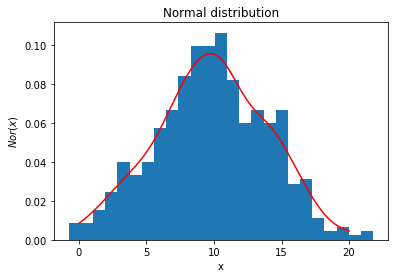

In [28]:
ax = plt.hist(x, bins=N//20, density=True)
plt.title('Normal distribution')
plt.xlabel('x')
plt.ylabel('$Nor(x)$')
plt.plot(X, np.sum(Y/x.size, axis=1),'r')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-18 11:01:01--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2020-11-18 11:01:01--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77905f7a8534afa357555b8b6f.dl.dropboxusercontent.com/cd/0/inline/BDbzt9aq-SM9xbp8JfDse4xqn91B5afYBbFIhPCaX2AD7GjGjeHXvHEIoqoKTJJ0XwNmJfeg94nP-5jkIGfI21fzKznhO6j_vZimEQ27u_QGhQ/file# [following]
--2020-11-18 11:01:02--  https://uc77905f7a8534afa357555b8b6f.dl.dropboxusercontent.com/cd/0/inline/BDbzt9aq-SM9xbp8JfDse4xqn91B5afYBbFIhPCaX2AD7GjGjeHXvHEIoqoKTJJ0XwNmJfeg94n

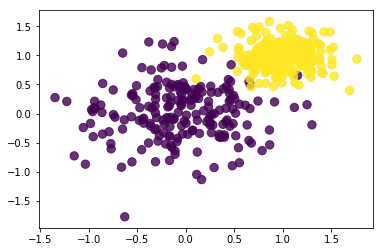

In [16]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

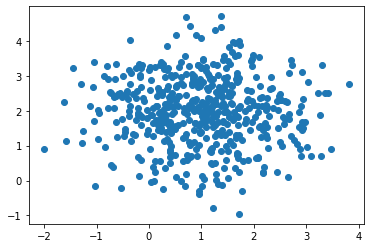

In [30]:
# Now we write a function that generate a 2d gaussian random variable using the one I write before for the 
# 1D case:
def array2Dnormallydistributed(mean, stdev, N):
    x = arraynormallydistributed(mean[0], stdev, N)
    y = arraynormallydistributed(mean[1], stdev, N)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    
    return np.concatenate((x,y), axis=1)
twod = array2Dnormallydistributed((1,2), 1, 500)

#let's test how it works:
x = twod[:,0]
y = twod[:,1]

plt.scatter(x,y)

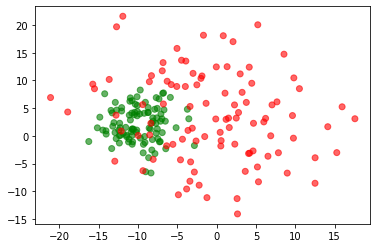

In [38]:
twod1 = array2Dnormallydistributed((-10,2), 3, 100)
twod2 = array2Dnormallydistributed((0,3), 8, 100)

color = []

for i in range(twod1.shape[0]):
    color.append('green')
    
for i in range(twod2.shape[0]):
    color.append('red')

twod = np.concatenate((twod1,twod2), axis=0)
x = twod[:,0]
y = twod[:,1]

len(color)
plt.scatter(x,y,c=color,alpha=.6)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [19]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-18 11:01:03--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-11-18 11:01:03--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0b56cf4fd501bb66dd11a71b47.dl.dropboxusercontent.com/cd/0/inline/BDbxfc3PQDyStCkaytSxu6VXkZ3jFOpl7GgXZrKXWRM2gRduDOpHMTLoqsMfqYPjA0r87J1zh_dW1vmisMlV2hDg97KcOgej1FZNCEWMVjzNLw/file# [following]
--2020-11-18 11:01:04--  https://uc0b56cf4fd501bb66dd11a71b47.dl.dropboxusercontent.com/cd/0/inline/BDbxfc3PQDyStCkaytSxu6VXkZ3jFOpl7GgXZrKXWRM2gRduDOpHMTLoqsMfqYPjA0r87J1zh_dW1vmisMlV2hDg97KcOgej1FZNCEWMVjzNLw/file
R

In [41]:
import pandas as pd

file = './residuals_261.npy'
data = np.load(file, allow_pickle=True).item()

data = pd.DataFrame(data)
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [42]:
newdata = data[data.iloc[:,0]<2]
newdata

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [43]:
from scipy import stats
import seaborn as sns
x = newdata.iloc[:,0]
y = newdata.iloc[:,1]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

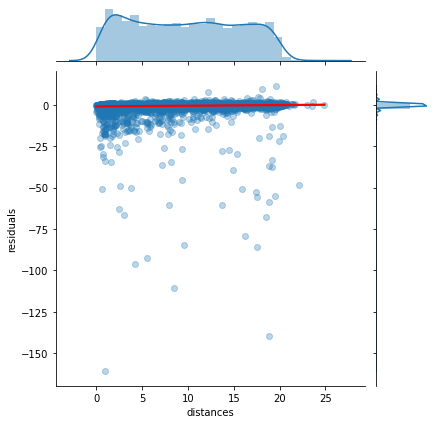

In [50]:
sns.jointplot("distances", "residuals", data=data, kind='reg', joint_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})

In [99]:
Nbins = 20

x = np.linspace(0,20,Nbins)
y = np.zeros(Nbins)
erry = np.zeros(Nbins)

for i in range(Nbins-1):
    tempdata = data[data.iloc[:,1]>= x[i]]
    tempdata = tempdata[tempdata.iloc[:,1] < x[i+1]]
    
    erry[i] = np.std(tempdata.iloc[:,0])
    y[i] = np.sum(tempdata.iloc[:,0],axis=0) / tempdata.shape[0]
    
#print(x.size == y.size)



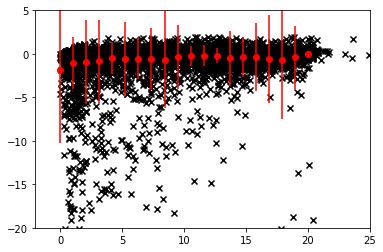

In [129]:
plt.scatter(newdata.iloc[:,1],newdata.iloc[:,0],marker='x',color='black')
plt.errorbar(x, y, yerr=erry,color ='red', fmt='o')
axes = plt.gca()
axes.set_xlim([-2,25])
axes.set_ylim([-20,5])
plt.show()

In [188]:
'''x = x.reshape(-1,1)
y = y.reshape(-1,1)
lastdata = np.concatenate((x,y),axis=1)

lastdataframe = pd.DataFrame(lastdata, index = None, columns=["distances", "residuals"])

sns.jointplot("distances", "residuals", data=data, kind='reg', joint_kws={'line_kws':{'color':'red'}},
              ylim=(-20,5),marker='x',color='black')
sns.relplot("distances", "residuals", data=lastdataframe, color='red')'''


'x = x.reshape(-1,1)\ny = y.reshape(-1,1)\nlastdata = np.concatenate((x,y),axis=1)\n\nlastdataframe = pd.DataFrame(lastdata, index = None, columns=["distances", "residuals"])\n\nsns.jointplot("distances", "residuals", data=data, kind=\'reg\', joint_kws={\'line_kws\':{\'color\':\'red\'}},\n              ylim=(-20,5),marker=\'x\',color=\'black\')\nsns.relplot("distances", "residuals", data=lastdataframe, color=\'red\')'